In [207]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [208]:
try:
    conn = sqlite3.connect('../data/checking-logs.sqlite')
    print("Успешное подключение к базе данных.")
except sqlite3.Error as e:
    print(f"Ошибка при подключении к базе данных: {e}")
    exit()

Успешное подключение к базе данных.


### Фреймворк данных, где каждый пользователь тестовой группы имеет среднюю разницу, количество просмотров страниц и количество комитов

In [209]:
query_commits = query_commits = """
    SELECT
        uid,
        COUNT(*) AS num_commits 
    FROM checker
    WHERE
        uid LIKE 'user_%'
        AND labname != 'project1'
    GROUP BY uid"""
num_commits = pd.read_sql_query(query_commits, conn)
num_commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


In [210]:
query_commits = """
    SELECT 
        uid,
        COUNT(*) AS num_view
    FROM pageviews
    WHERE
        uid LIKE 'user_%'
    GROUP BY uid"""
num_view = pd.read_sql_query(query_commits, conn)
num_view

,uid,num_view
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [211]:
query = """
    SELECT
        t.uid,
        CAST((JULIANDAY(t.first_commit_ts) - JULIANDAY(d.deadlines, 'unixepoch')) * 24 AS INTEGER) AS delta
    FROM test AS t
    LEFT JOIN deadlines AS d ON t.labname = d.labs
    WHERE t.labname != 'project1'
"""
delta_hours = pd.read_sql_query(query, conn)
delta_hours = delta_hours.groupby(['uid']).mean()
delta_hours

,delta
uid,
user_1,-64.400000
user_10,-74.800000
user_14,-159.000000
user_17,-61.600000
user_18,-5.666667
user_19,-98.750000
user_21,-95.500000
user_25,-92.600000
user_28,-86.400000


In [212]:
pivot_table = num_view.merge(num_commits, on=['uid'])
pivot_table = delta_hours.merge(pivot_table, on=['uid'])
pivot_table

,uid,delta,num_view,num_commits
0,user_1,-64.400000,28,62
1,user_10,-74.800000,89,20
2,user_14,-159.000000,143,61
3,user_17,-61.600000,47,51
4,user_18,-5.666667,3,5
5,user_19,-98.750000,16,118
6,user_21,-95.500000,10,65
7,user_25,-92.600000,179,79
8,user_28,-86.400000,149,60
9,user_3,-105.400000,317,18


### Построение графика

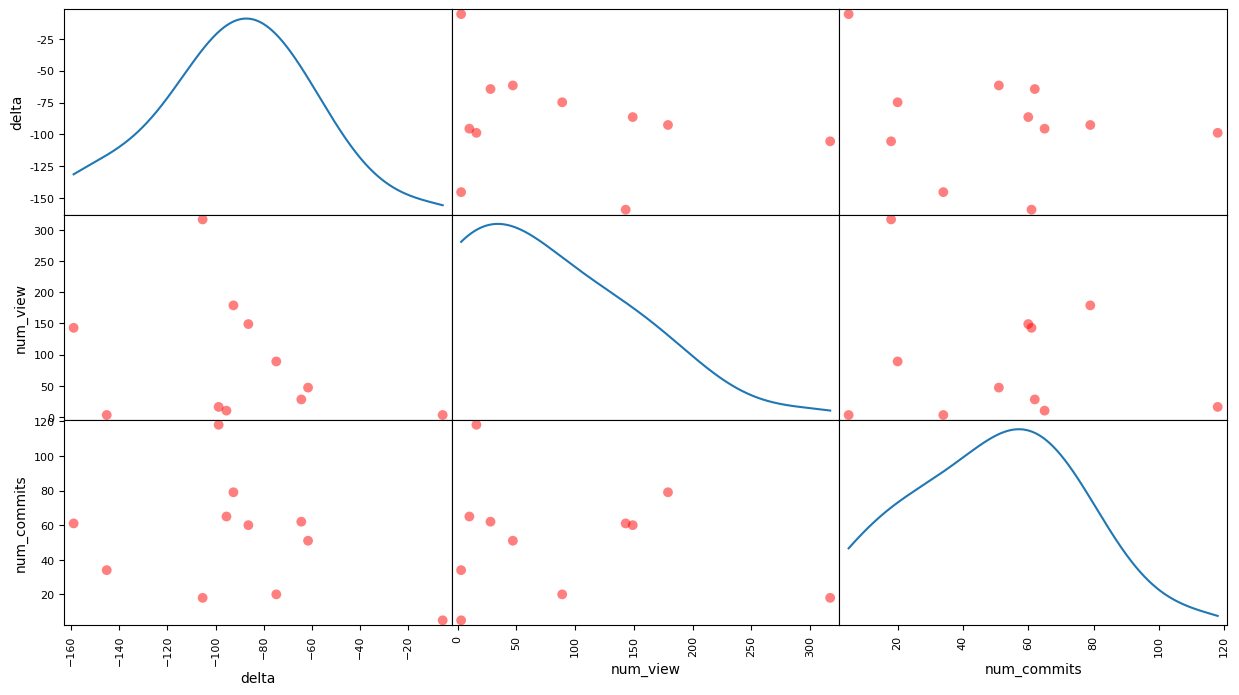

In [213]:
ax = scatter_matrix(pivot_table, figsize=(15, 8), diagonal='kde', s=200, color='red')

### Можно ли сказать, что если у пользователя мало просмотров страниц, то у него, скорее всего, мало и коммитов?
* Ответ: нет.

### Можем ли мы сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него небольшая средняя разница между первым коммитом и крайним сроком выполнения лабораторных работ?
* Ответ: нет.

### Можем ли мы сказать, что есть много пользователей с малым количеством коммитов и несколько с большим количеством коммитов?
* Ответ: да.



### Можно ли сказать, что есть много пользователей с небольшой средней разницей и несколько с большой средней разницей? 
* Ответ: да.